In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
#!pip install kagglehub
import kagglehub
import os

path_dm = kagglehub.dataset_download("mkechinov/direct-messaging")
print("Available files:", os.listdir(path_dm))
file_path = os.path.join(path_dm, "messages-demo.csv")
df_dm = pd.read_csv(file_path, nrows=1000)  
print(df_dm.head())

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available files: ['messages-demo.csv', 'campaigns.csv', 'holidays.csv', 'client_first_purchase_date.csv']
        id                            message_id  campaign_id   message_type  \
0  3527358  3f6aaad3-bab7-4886-b083-fe8c1f210066           31  transactional   
1  3527619  0e670ecc-4549-44f6-86ed-469682d34837           32  transactional   
2  3527980  276b25cf-1bda-4faf-b3a4-98e4161f9357           32  transactional   
3  3528369  4545aff2-09b3-45e3-9abd-c680357e5429           32  transactional   
4  3528648  5850858d-2dcf-4f31-a0d3-5db5649b17c4           32  transactional   

             client_id channel  category  platform email_provider   stream  \
0  1515915625489833514   email       NaN       NaN        mail.ru  desktop   
1  1515915625489220445   email       NaN       NaN      yandex.ru  desktop   
2  1515915625489854185   email       NaN       NaN        mail.ru  desktop   
3  1515915625489101550   email       NaN       NaN        mail.ru  desktop   
4  1515915625490455948 

In [3]:
path_mkt = kagglehub.dataset_download("imranalishahh/marketing-and-product-performance-dataset")
print("Files in Marketing dataset:", os.listdir(path_mkt))
df_mkt = pd.read_csv(os.path.join(path_mkt, "marketing_and_product_performance.csv"))
print(df_mkt.head())

Files in Marketing dataset: ['marketing_and_product_performance.csv']
  Campaign_ID   Product_ID    Budget  Clicks  Conversions  Revenue_Generated  \
0  CMP_RLSDVN  PROD_HBJFA3  41770.45    4946           73           15520.09   
1  CMP_JHHUE9  PROD_OE8YNJ  29900.93     570          510           30866.17   
2  CMP_6SBOWN  PROD_4V8A08  22367.45    3546          265           32585.62   
3  CMP_Q31QCU  PROD_A1Q6ZB  29957.54    2573          781           95740.12   
4  CMP_AY0UTJ  PROD_F57N66  36277.19     818           79           81990.43   

    ROI  Customer_ID Subscription_Tier  Subscription_Length Flash_Sale_ID  \
0  1.94  CUST_1K7G39           Premium                    4  FLASH_1VFK5K   
1  0.76  CUST_0DWS6F           Premium                    4  FLASH_1M6COK   
2  1.41  CUST_BR2GST             Basic                    9  FLASH_J4PEON   
3  3.32  CUST_6TBY6K           Premium                   32  FLASH_1TOVXT   
4  3.53  CUST_XASI45          Standard                   29  FLA

In [4]:
path_cust = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
print("Files in Customer Personality dataset:", os.listdir(path_cust))
df_cust = pd.read_csv(os.path.join(path_cust, "marketing_campaign.csv"), sep="\t", encoding="latin1")
print(df_cust.head())

Files in Customer Personality dataset: ['marketing_campaign.csv']
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  Acc

In [5]:
#CUSTOMER PERSONALITY
cust = df_cust.copy()

if 'Income' in cust.columns:
    cust = cust[cust['Income'].between(cust['Income'].quantile(0.01),
                                       cust['Income'].quantile(0.99))]

if 'Dt_Customer' in cust.columns:
    cust['Dt_Customer'] = pd.to_datetime(cust['Dt_Customer'], errors='coerce')
    cust['TenureDays'] = (cust['Dt_Customer'].max() - cust['Dt_Customer']).dt.days

TARGET_COL = 'Response'

numeric_features = [c for c in [
    'Income','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts',
    'MntSweetProducts','MntGoldProds','Kidhome','Teenhome','TenureDays'
] if c in cust.columns]

categorical_features = [c for c in ['Education','Marital_Status'] if c in cust.columns]

for col in numeric_features:
    if cust[col].isna().any():
        cust[col] = cust[col].fillna(cust[col].median())
for col in categorical_features:
    if cust[col].isna().any():
        cust[col] = cust[col].fillna(cust[col].mode().iloc[0])

df = cust.dropna(subset=[TARGET_COL]).copy()
X = df[numeric_features + categorical_features]
y = df[TARGET_COL].astype(int)

In [6]:
#MARKETING PERFORMANCE
mkt = df_mkt.copy()

assert 'ROI' in mkt.columns, "ROI column not found."
mkt = mkt[mkt['ROI'].notna()].copy()
mkt['High_ROI'] = (mkt['ROI'] >= 1.0).astype(int)
TARGET_COL = 'High_ROI'

numeric_features = [c for c in [
    'Budget','Clicks','Conversions','Revenue_Generated','Units_Sold','Bundle_Price'
] if c in mkt.columns]

categorical_features = [c for c in [
    'Subscription_Tier','Subscription_Length','Discount_Level','Common_Keywords'
] if c in mkt.columns]

for col in numeric_features:
    if mkt[col].isna().any():
        mkt[col] = mkt[col].fillna(mkt[col].median())
for col in categorical_features:
    if mkt[col].isna().any():
        mkt[col] = mkt[col].fillna(mkt[col].mode().iloc[0])

X = mkt[numeric_features + categorical_features]
y = mkt[TARGET_COL].astype(int)

In [7]:
def run_week4_logreg(
    X, y, numeric_features, categorical_features, *,
    title="Model", class_weight=None, max_iter=1000, random_state=42
):
    
    assert set(np.unique(y)).issubset({0, 1}), "y must be binary 0/1"
    vc = pd.Series(y).value_counts()
    if vc.min() == 0:
        raise ValueError("One class has 0 samples.")
    print(f"{title} — class balance:\n{(vc / vc.sum()).round(3)}\n")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=random_state
    )

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ],
        remainder="drop",
    )

    log_reg = LogisticRegression(max_iter=max_iter, class_weight=class_weight)
    pipe = Pipeline([("pre", pre), ("clf", log_reg)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{title} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} — ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    cat_names = []
    if len(categorical_features) > 0:
        ohe = pipe.named_steps["pre"].named_transformers_["cat"]  
        try:
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        except Exception:
            cat_names = []
            for col, cats in zip(categorical_features, ohe.categories_):
                cat_names.extend([f"{col}={c}" for c in cats])

    feat_names = list(numeric_features) + cat_names
    coefs = pipe.named_steps["clf"].coef_.ravel()
    coef_df = (
        pd.DataFrame({"feature": feat_names, "coef": coefs, "abs_coef": np.abs(coefs)})
        .sort_values("abs_coef", ascending=False)
    )
    print("\nTop drivers by |coef|:")
    display(coef_df.head(20))

    return {"pipeline": pipe, "coef_df": coef_df, "auc": auc_val}

In [8]:
dm = df_dm.copy()

dm.rename(columns=lambda x: str(x).strip(), inplace=True)

print("Cols containing 'purch':", [c for c in dm.columns if 'purch' in c.lower()])

TARGET_COL = "is_purchased"
assert TARGET_COL in dm.columns, f"Couldn't find '{TARGET_COL}' in columns. Found: {dm.columns.tolist()}"

dm[TARGET_COL] = (
    dm[TARGET_COL].astype(str).str.strip().str.lower()
      .map({"t":1, "true":1, "1":1, "f":0, "false":0, "0":0})
)

for c in ["created_at", "purchased_at", "blocked_at"]:
    if c in dm.columns:
        dm[c] = pd.to_datetime(dm[c], errors="coerce")

if "created_at" in dm.columns:
    dm["created_hour"] = dm["created_at"].dt.hour
    dm["created_dow"]  = dm["created_at"].dt.dayofweek

for c in ["is_soft_bounced","is_complained","is_blocked","soft_bounced","complained_at"]:
    if c in dm.columns:
        dm[c] = (
            dm[c].astype(str).str.strip().str.lower()
                 .map({"t":1,"true":1,"1":1,"f":0,"false":0,"0":0})
        )

numeric_features = [c for c in ["created_hour","created_dow"] if c in dm.columns]
categorical_features = [c for c in ["message_type","channel","category","platform",
                                    "email_provider","stream"] if c in dm.columns]

df_nonnull = dm.loc[dm[TARGET_COL].isin([0,1])].copy()
X_dm = df_nonnull[numeric_features + categorical_features].copy()
y_dm = df_nonnull[TARGET_COL].astype(int)

num_dm = numeric_features.copy()
cat_dm = categorical_features.copy()

print("DM shapes:", X_dm.shape, y_dm.shape)


Cols containing 'purch': ['is_purchased', 'purchased_at']
DM shapes: (1000, 8) (1000,)


Direct Messaging — is_purchased — class balance:
is_purchased
0    0.98
1    0.02
Name: count, dtype: float64

Classification report:
              precision    recall  f1-score   support

           0      0.982     0.561     0.714       196
           1      0.023     0.500     0.043         4

    accuracy                          0.560       200
   macro avg      0.502     0.531     0.379       200
weighted avg      0.963     0.560     0.701       200



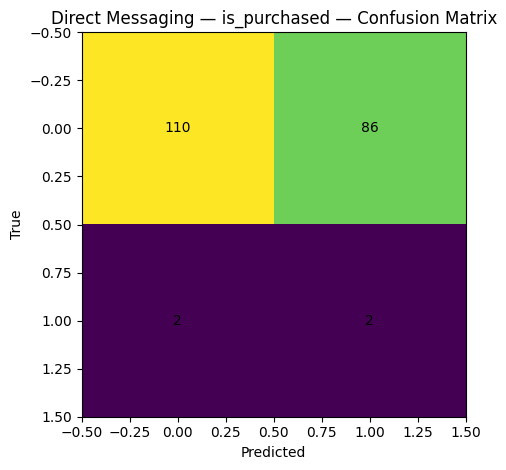

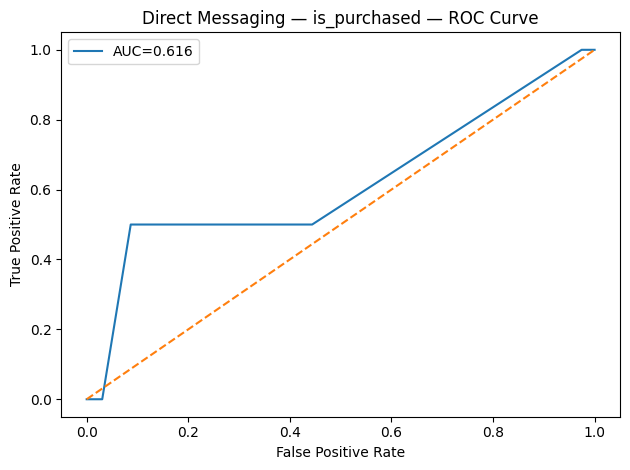


Top drivers by |coef|:


,feature,coef,abs_coef
12,email_provider_rambler.ru,-1.541552,1.541552
10,email_provider_list.ru,1.481810,1.481810
9,email_provider_inbox.ru,-1.130166,1.130166
6,email_provider_bk.ru,1.095277,1.095277
13,email_provider_ya.ru,-0.689088,0.689088
14,email_provider_yandex.ru,0.588632,0.588632
7,email_provider_gmail.com,0.375466,0.375466
8,email_provider_icloud.com,-0.175316,0.175316
11,email_provider_mail.ru,-0.049003,0.049003
3,channel_email,-0.043939,0.043939


In [9]:
results_dm = run_week4_logreg(
    X_dm, y_dm,
    numeric_features=num_dm,
    categorical_features=cat_dm,
    title="Direct Messaging — is_purchased",
    class_weight="balanced"
)


Direct Messaging — is_purchased — class balance:
is_purchased
0    0.98
1    0.02
Name: count, dtype: float64

Classification report:
              precision    recall  f1-score   support

           0      0.982     0.561     0.714       196
           1      0.023     0.500     0.043         4

    accuracy                          0.560       200
   macro avg      0.502     0.531     0.379       200
weighted avg      0.963     0.560     0.701       200



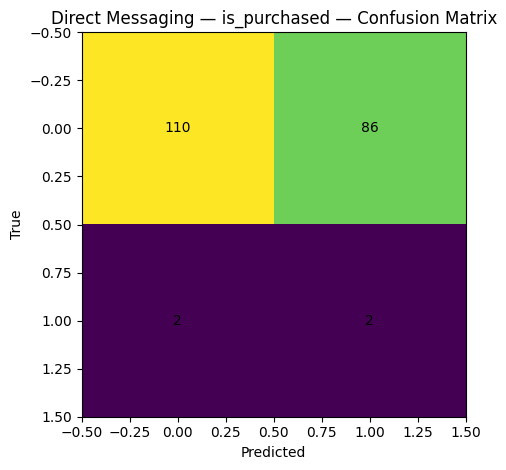

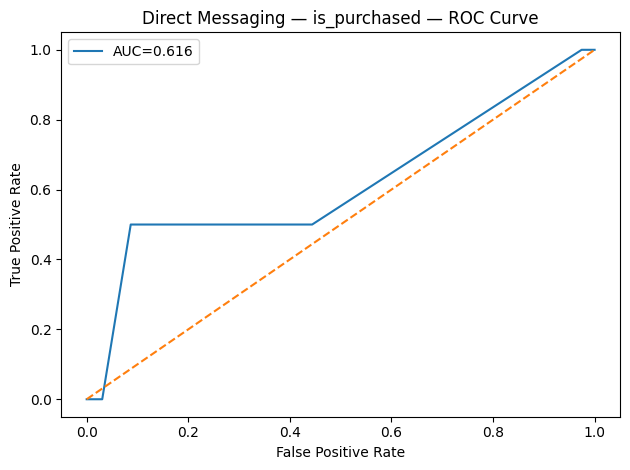


Top drivers by |coef|:


,feature,coef,abs_coef
12,email_provider_rambler.ru,-1.541552,1.541552
10,email_provider_list.ru,1.481810,1.481810
9,email_provider_inbox.ru,-1.130166,1.130166
6,email_provider_bk.ru,1.095277,1.095277
13,email_provider_ya.ru,-0.689088,0.689088
14,email_provider_yandex.ru,0.588632,0.588632
7,email_provider_gmail.com,0.375466,0.375466
8,email_provider_icloud.com,-0.175316,0.175316
11,email_provider_mail.ru,-0.049003,0.049003
3,channel_email,-0.043939,0.043939


In [10]:
results_dm = run_week4_logreg(
    X_dm, y_dm,
    numeric_features=num_dm,          
    categorical_features=cat_dm,     
    title="Direct Messaging — is_purchased",
    class_weight="balanced"
)


In [12]:
cust = df_cust.copy()
cust.rename(columns=lambda x: str(x).strip(), inplace=True)

if "Dt_Customer" in cust.columns:
    cust["Dt_Customer"] = pd.to_datetime(cust["Dt_Customer"], errors="coerce")
    cust["TenureDays"] = (cust["Dt_Customer"].max() - cust["Dt_Customer"]).dt.days

TARGET_COL = "Response"

numeric_features = [c for c in [
    "Income","Recency","MntWines","MntFruits","MntMeatProducts","MntFishProducts",
    "MntSweetProducts","MntGoldProds","Kidhome","Teenhome","TenureDays"
] if c in cust.columns]

categorical_features = [c for c in ["Education","Marital_Status"] if c in cust.columns]

for col in numeric_features:
    if cust[col].isna().any():
        cust[col] = cust[col].fillna(cust[col].median())
for col in categorical_features:
    if cust[col].isna().any():
        cust[col] = cust[col].fillna(cust[col].mode().iloc[0])

cust = cust.dropna(subset=[TARGET_COL]).copy()
X_cust = cust[numeric_features + categorical_features].copy()
y_cust = cust[TARGET_COL].astype(int)

num_cust = numeric_features.copy()
cat_cust = categorical_features.copy()

print("Cust shapes:", X_cust.shape, y_cust.shape)
print("First few columns:", X_cust.columns.tolist()[:8])

Cust shapes: (2240, 13) (2240,)
First few columns: ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


Customer Personality — Response — class balance:
Response
0    0.851
1    0.149
Name: count, dtype: float64

Classification report:
              precision    recall  f1-score   support

           0      0.879     0.974     0.924       381
           1      0.615     0.239     0.344        67

    accuracy                          0.864       448
   macro avg      0.747     0.606     0.634       448
weighted avg      0.840     0.864     0.837       448



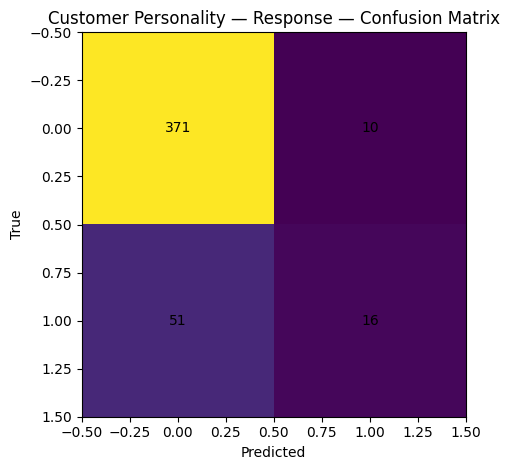

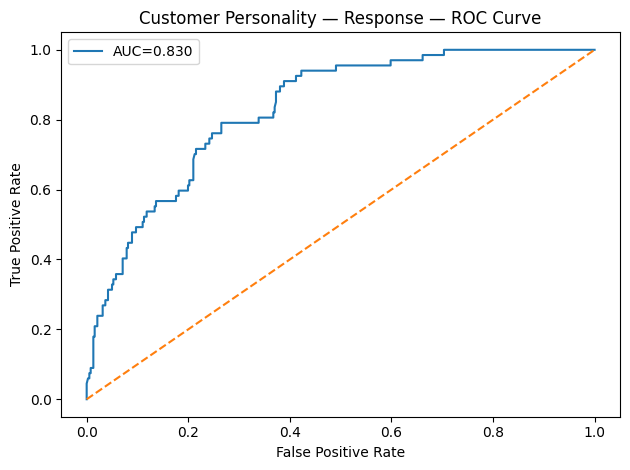


Top drivers by |coef|:


,feature,coef,abs_coef
21,Marital_Status_Together,-0.982582,0.982582
19,Marital_Status_Married,-0.920839,0.920839
12,Education_Basic,-0.808765,0.808765
1,Recency,-0.743058,0.743058
2,MntWines,0.587193,0.587193
15,Education_PhD,0.557701,0.557701
16,Marital_Status_Absurd,0.539233,0.539233
9,Teenhome,-0.486011,0.486011
17,Marital_Status_Alone,0.461829,0.461829
10,TenureDays,0.418100,0.418100


In [14]:
results_cust = run_week4_logreg(
    X_cust, y_cust,
    numeric_features=num_cust,          
    categorical_features=cat_cust,      
    title="Customer Personality — Response"
)

In [16]:
mkt = df_mkt.copy()
mkt.rename(columns=lambda x: str(x).strip(), inplace=True)

assert "ROI" in mkt.columns, "ROI column not found in marketing dataset."
mkt = mkt[mkt["ROI"].notna()].copy()
mkt["High_ROI"] = (mkt["ROI"] >= 1.0).astype(int)
TARGET_COL = "High_ROI"

numeric_features = [c for c in [
    "Budget","Clicks","Conversions","Revenue_Generated","Units_Sold","Bundle_Price"
] if c in mkt.columns]

categorical_features = [c for c in [
    "Subscription_Tier","Subscription_Length","Discount_Level","Common_Keywords"
] if c in mkt.columns]

for col in numeric_features:
    if mkt[col].isna().any():
        mkt[col] = mkt[col].fillna(mkt[col].median())
for col in categorical_features:
    if mkt[col].isna().any():
        mkt[col] = mkt[col].fillna(mkt[col].mode().iloc[0])

X_mkt = mkt[numeric_features + categorical_features].copy()
y_mkt = mkt[TARGET_COL].astype(int)

num_mkt = numeric_features.copy()
cat_mkt = categorical_features.copy()

print("MKT shapes:", X_mkt.shape, y_mkt.shape)
print("MKT first cols:", X_mkt.columns.tolist()[:8])

MKT shapes: (10000, 10) (10000,)
MKT first cols: ['Budget', 'Clicks', 'Conversions', 'Revenue_Generated', 'Units_Sold', 'Bundle_Price', 'Subscription_Tier', 'Subscription_Length']


Marketing Performance — High_ROI — class balance:
High_ROI
1    0.892
0    0.108
Name: count, dtype: float64

Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       217
           1      0.891     1.000     0.943      1783

    accuracy                          0.891      2000
   macro avg      0.446     0.500     0.471      2000
weighted avg      0.795     0.891     0.840      2000



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


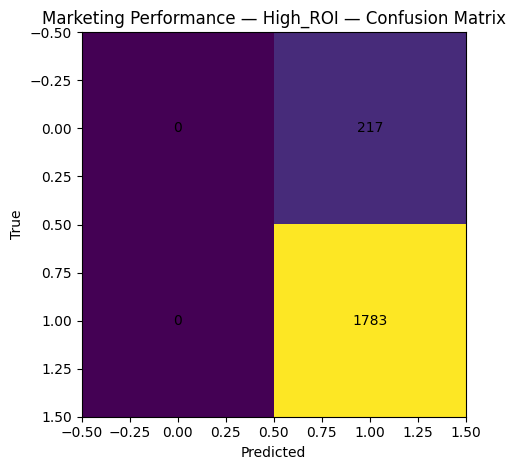

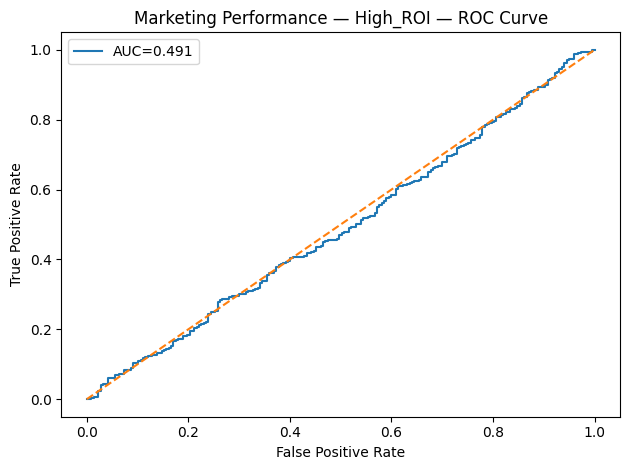


Top drivers by |coef|:


,feature,coef,abs_coef
98,Discount_Level_64,0.651009,0.651009
77,Discount_Level_43,0.571262,0.571262
78,Discount_Level_44,-0.522629,0.522629
53,Discount_Level_19,-0.502655,0.502655
74,Discount_Level_40,-0.462985,0.462985
52,Discount_Level_18,0.444309,0.444309
8,Subscription_Tier_Standard,0.439707,0.439707
82,Discount_Level_48,0.424678,0.424678
11,Subscription_Length_3,-0.398320,0.398320
107,Common_Keywords_Stylish,0.394706,0.394706


In [19]:
results_mkt = run_week4_logreg(
    X_mkt, y_mkt,
    numeric_features=num_mkt,          
    categorical_features=cat_mkt,     
    title="Marketing Performance — High_ROI"
)